In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import BertTokenizer, BertModel

import torch

import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit

import xgboost
from xgboost import XGBClassifier

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm

# Import custom class
from BertSeqVect import BertSequenceVectorizer

# Set wd
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')

# Enable tqdm progress bars on pandas
tqdm.pandas()

2024-03-08 16:11:49.751181: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 16:11:49.793397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 16:11:49.793426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 16:11:49.794518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 16:11:49.800959: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# # Print versions
# print("Python version:", sys.version)
# print("numpy:", np.__version__)
# print("pandas:", pd.__version__)
# print("nltk:", nltk.__version__)
# print("torch:", torch.__version__)
# print("sklearn:", sklearn.__version__)
# print("tensorflow:", tf.__version__)
# print("transformers:", transformers.__version__)
# print("xgboost:", xgboost.__version__)
# print("imblearn:", imblearn.__version__)

In [2]:
df = pd.read_csv('Speeches_War_Clean.csv')

## Class imbalance:

### We adjust this later via SMOTE

In [3]:
old_class_counts = df['War'].value_counts()
print(old_class_counts)

War
0    887
1     81
Name: count, dtype: int64


___

### Vectorization: Applying the vectorize method from the `BertSequenceVectorizer` class to each speech to convert them into fixed-length vectors.

Instantiate BERT tokenizer and model:

In [4]:
# Instantiate BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Process each transcript using the BERT-large-uncased model to obtain a fixed-length vector representation by using the `BertSequenceVectorizer` class (see BertSeqVect.py). 

The resulting vectors are stored in `df` in the `ts_feature` column.

In [5]:
vectorizer = BertSequenceVectorizer()

# Apply BERT sequence vectorization to transcripts
df['ts_feature'] = df['Transcript'].progress_apply(lambda x: vectorizer.vectorize(x))

100%|██████████| 968/968 [00:48<00:00, 20.05it/s]


### Oversample via SMOTE:

Apply SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance. This effectively oversamples the minority class (`War=1`, in this case) to balance the class distribution. The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class, so we perform this via a pipeline that combines the two transformations.

Below we generate the resampled features, `X_resampled`, and corresponding labels, `y_resampled`.

In [6]:
print((df['ts_feature'][0]).shape)

(768,)


In [7]:
# Function to check if all arrays in a column have the same shape
def check_same_shape(arrays):
    shapes = [np.array(arr).shape for arr in arrays]
    return len(set(shapes)) == 1

In [8]:
# Check if all arrays in the 'arrays' column have the same shape
result = check_same_shape(df['ts_feature'])
print("All arrays have the same shape:", result)

All arrays have the same shape: True


In [9]:
# Extract features from 'ts_feature'
X = np.stack(df['ts_feature'].values)

In [10]:
# define pipeline
over = SMOTE(sampling_strategy=0.6, random_state=28)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=28)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [11]:
# Transform the data
X_resampled, y_resampled = pipeline.fit_resample(X, df['War'])

In [12]:
new_class_counts = y_resampled.value_counts()
new_class_counts = new_class_counts.sort_index()

print(new_class_counts)

War
0    665
1    532
Name: count, dtype: int64


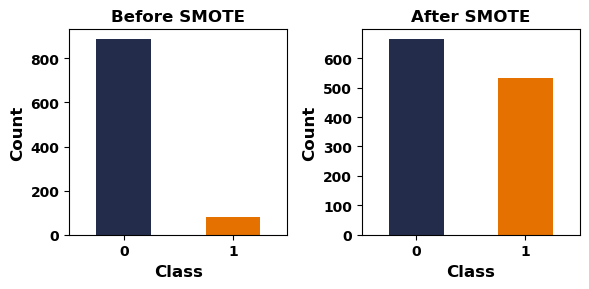

In [13]:
# Visualize change in class imbalance
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
old_class_counts.plot(kind='bar', color=['#232D4B', '#E57200'])
plt.title('Before SMOTE', weight='bold')
plt.xlabel('Class', weight='bold', size=12)
plt.ylabel('Count', weight='bold', size=12)
plt.xticks(rotation=0, weight='bold')  # Make xticks bold
plt.yticks(weight='bold')  # Make yticks bold

plt.subplot(1, 2, 2)
new_class_counts.plot(kind='bar', color=['#232D4B', '#E57200'])
plt.title('After SMOTE', weight='bold')
plt.xlabel('Class', weight='bold', size=12)
plt.ylabel('Count', weight='bold', size=12)
plt.xticks(rotation=0, weight='bold')  # Make xticks bold
plt.yticks(weight='bold')  # Make yticks bold

plt.tight_layout()
plt.show()

### Train/test split

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=28)

In [15]:
# Determine the input shape
input_shape = (X_train.shape[1:])

### Exploring a Basic NN

In [16]:
# Define the neural network model
model = Sequential([
    Input(shape=input_shape),
    Dense(128, 
          activation='relu', 
          input_shape=(768,),
          kernel_initializer='he_normal', 
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64, 
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1, 
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

/home/bdr6qz/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-03-08 16:14:35.004936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30446 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0
2024-03-08 16:14:35.005908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31118 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [17]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01)#, use_ema=True, ema_momentum=0.9)
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True)
#opt = tf.keras.optimizers.Adadelta(learning_rate=0.01, use_ema=True, ema_momentum=0.99)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_split=0.15)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7230 - loss: 2.3669 - val_accuracy: 0.7431 - val_loss: 2.1111
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7547 - loss: 1.9844 - val_accuracy: 0.8056 - val_loss: 1.7341
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8572 - loss: 1.5750 - val_accuracy: 0.8264 - val_loss: 1.4250
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8796 - loss: 1.2923 - val_accuracy: 0.8611 - val_loss: 1.2094
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8847 - loss: 1.0777 - val_accuracy: 0.8819 - val_loss: 1.0172
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9004 - loss: 0.9161 - val_accuracy: 0.8681 - val_loss: 0.9333
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9382 - loss: 0.7463 - val_accuracy: 0.8958 - val_loss: 0.7995
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9516 - loss: 0.6456 - val_accuracy: 0.8958 - val_loss:

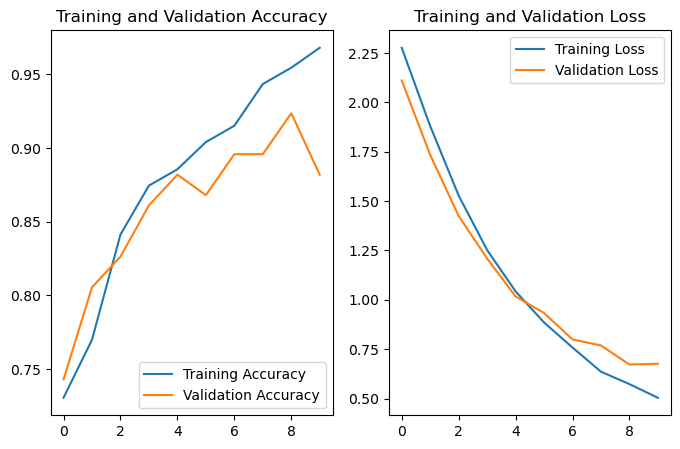

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
AUC-ROC Score: 0.9551250089037682
F1-Score: 0.8706896551724138


W0000 00:00:1709932519.219645  879838 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709932519.361680  879840 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


---

# Comments on model results:

These results possibly indicate that there are discernible patterns in the text of US presidential speeches that correlate with the US entering a major war  within one year of the speech. This (I think) suggests that Presidents leverage certain language or rhetorical cues in their speeches to prepare the nation for war.

# Next Steps:

Professor mentioned that it would be interesting if we can try to identify discriminative features between the two classes (i.e., Interpretable Learning). So, see if we could answer questions like: What is the model seeing in the speech that makes it classify it as leading up to war or what is missing in the other class that makes it classify that way?

To tackle this we might consider:

### __1__: Layer-wise Relevance Propagation (LRP):

Implement LRP to understand the relevance of input features to the model's predictions. This can help us identify which words or phrases in the speeches contribute most significantly to the classification decision.

### __2__: SHAP (SHapley Additive exPlanations):

Use SHAP values to compute the importance of each feature in the context of individual predictions. This technique will provide insights into how each feature influences the model's output.

### __3__: Feature Importance Scores:

After training your model, extract the weights of the first layer (Dense(128)) and analyze which input features have the highest weights. This can give us an idea of which words or phrases are most influential in determining the classification.

### __4__: Attention Mechanisms:

If applicable, incorporate attention mechanisms into your model architecture. Attention mechanisms can highlight which parts of the input sequence are most relevant for making predictions, providing interpretability at the token level.

### __5__: Word Embedding Visualization:

Visualize word embeddings to understand how words are represented in the model's embedding space. This can help us identify clusters of words associated with specific classes (e.g., words related to war).

### __6__: Grad-CAM (Gradient-weighted Class Activation Mapping):

If we use a model architecture with convolutional layers, we might consider apply Grad-CAM to visualize which parts of the input text are most important for the model's predictions. This technique highlights regions of the input that contribute most to the final decision.